In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import molsysmt as msm
import openexplorer as oe
import numpy as np
from simtk import unit
from simtk.openmm import app
from tqdm import tqdm
import matplotlib.pyplot as plt

/home/diego/MyMachine/locals/miniconda/envs/OpenExplorer/lib/python3.7/site-packages/MDAnalysis/coordinates/chemfiles.py:108: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  MIN_CHEMFILES_VERSION = LooseVersion("0.9")


no need to add nglview patch


# 1D Double Well

In [3]:
from uibcdf_test_systems.systems import DoubleWell

double_well_symmetric = DoubleWell(n_particles = 1, mass = 64 * unit.amu, Eo=3.0 * unit.kilocalories_per_mole,
                                   a=1.0 * unit.nanometers, b=0.0 * unit.kilocalories_per_mole)


ModuleNotFoundError: No module named 'uibcdf_test_systems'

In [4]:
explorer = oe.Explorer(double_well_symmetric.topology, double_well_symmetric.system, platform='CUDA')
explorer.set_coordinates([[1.0, 0.0, 0.0]]*unit.nanometers)

In [5]:
explorer.quench.l_bfgs()

In [6]:
explorer.get_coordinates()

Quantity(value=array([[1., 0., 0.]]), unit=nanometer)

In [7]:
explorer.get_potential_energy()

Quantity(value=-12.552000045776367, unit=kilojoule/mole)

In [8]:
minima, periods = double_well_symmetric.harmonic_oscillation_periods()

In [9]:
print(periods)

[Quantity(value=array([5.01612553, 5.01612553, 5.01612553]), unit=picosecond), Quantity(value=array([5.01612553, 5.01612553, 5.01612553]), unit=picosecond)]


In [10]:
minima, sigmas = double_well_symmetric.harmonic_standard_deviations()

In [11]:
print(sigmas)

[Quantity(value=array([0.15708113, 0.15708113, 0.15708113]), unit=nanometer), Quantity(value=array([0.15708113, 0.15708113, 0.15708113]), unit=nanometer)]


## MonteCarlo

### Mis preguntas

- Será que hay un compromiso entre longitud de paso y aceptación? la termodinámica convergerá antes si el paso es grande aun a costa de bajar la tasa de aceptación? No creo ¿verdad? Porque lo que no se acepta se repite.

In [12]:
explorer.set_coordinates([[1.0, 0.0, 0.0]]*unit.nanometers)
explorer.quench.l_bfgs()

In [13]:
explorer.move.cartesian_shifts.set_parameters(mode_atoms='all', stepsize=1.77*0.157*unit.nanometers)
explorer.acceptance.metropolis_hastings.set_parameters(temperature=298.0*unit.kelvin)

In [14]:
n_moves = 250000
trajectory = []*unit.nanometers
potential_energies = []*unit.kilojoules_per_mole

previous_coordinates = explorer.get_coordinates()
previous_potential_energy = explorer.get_potential_energy()

trajectory.append(previous_coordinates)
potential_energies.append(previous_potential_energy)

for _ in tqdm(range(n_moves)):
    explorer.move.cartesian_shifts()    
    explorer.acceptance.metropolis_hastings(previous_coordinates=previous_coordinates,
                                            previous_potential_energy=previous_potential_energy)
    if explorer.acceptance.metropolis_hastings.accepted:
        previous_coordinates = explorer.get_coordinates()
        previous_potential_energy = explorer.get_potential_energy()
    trajectory.append(previous_coordinates)
    potential_energies.append(previous_potential_energy)

100%|██████████| 250000/250000 [04:33<00:00, 913.56it/s] 


In [15]:
explorer.acceptance.metropolis_hastings.n_accepted

2857

In [16]:
trajectory._value = np.array(trajectory._value)

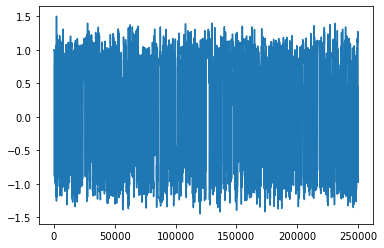

In [17]:
plt.plot(trajectory[:,0,0])
plt.show()

In [18]:
trajectory2 = trajectory**2

x_med = np.zeros(trajectory.shape)*trajectory.unit
x2_med = np.zeros(trajectory.shape)*trajectory2.unit

for ii in range(trajectory.shape[0]):
    x_med[ii]=trajectory[:ii].mean()
    x2_med[ii]=trajectory2[:ii].mean()

/home/diego/Myusr/opt/miniconda3/envs/UIBCDF_lab_dev/lib/python3.7/site-packages/simtk/unit/quantity.py:494: RuntimeWarning: Mean of empty slice.
  mean = self._value.mean(*args, **kwargs)
/home/diego/Myusr/opt/miniconda3/envs/UIBCDF_lab_dev/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [19]:
x_med.shape

(250001, 1, 3)

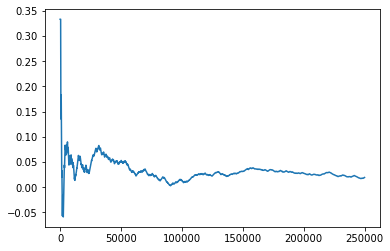

In [20]:
plt.plot(x_med[:,0,0])
plt.show()

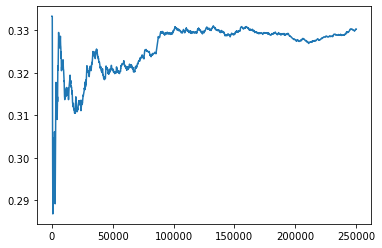

In [21]:
plt.plot(x2_med[:,0,0])
plt.show()

## Langevin Dynamics

In [ ]:
explorer.md.langevin.set_parameters(timestep=0.2*unit.picoseconds)

In [ ]:
explorer.md.langevin.get_parameters()

In [ ]:
explorer.set_coordinates([[1.0, 0.0, 0.0]]*unit.nanometers)
explorer.quench.l_bfgs()

In [ ]:
trajectory = []*unit.nanometers
potential_energies = []*unit.kilojoules_per_mole
time = []*unit.picoseconds

saving_time = 0.2*unit.picoseconds
md_time = 50*unit.nanoseconds
timestep = explorer.md.langevin.get_parameters()['timestep']

n_steps_cicle = int(saving_time/timestep)
n_cicles = int(md_time/saving_time)

for _ in tqdm(range(n_cicles)):
    explorer.md.langevin(n_steps_cicle)
    trajectory.append(explorer.get_coordinates())
    time(explorer.md.langevin.get_time())
    potential_energies.append(explorer.get_potential_energy())

In [ ]:
time._value = np.array(time._value)
trajectory._value = np.array(trajectory._value)

In [ ]:
total_n_steps = n_cicles*n_steps_cicle
print(total_n_steps)

In [ ]:
plt.plot(time, trajectory)
plt.show()

In [ ]:
trajectory2 = trajectory**2

In [ ]:
x_med = np.zeros(trajectory.shape)*trajectory.unit
x2_med = np.zeros(trajectory.shape)*trajectory2.unit

In [ ]:
for ii in range(trajectory.shape[0]):
    x_med[ii]=trajectory[:ii].mean()
    x2_med[ii]=trajectory2[:ii].mean()

In [ ]:
plt.plot(time, x_med)
plt.show()

In [ ]:
plt.plot(time, x2_med)
plt.show()

- Para elegir el movimiento puedo monitorizar también el delta X 2 promedio de los aceptados
- Ver pag 47 of Understanding Molecular Simulations

## Mixed MonteCarlo and Stochastic Dynamics